In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

from discriminator import Discriminator
from generator import Generator

from torch.utils.data import DataLoader, Dataset


from utils import *
import torchvision
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:


def visualize(dataloader, netG, netD, criterion, epoch, fixed_noise, device):
    real_batch = next(iter(dataloader))
    y_labels = real_batch[1].to(device)
    real_batch = real_batch[0].to(device)
    
    batch_size = real_batch.size(0)
    label = torch.full((batch_size,), 1.0, device=device)
    output = netD(real_batch, y_labels).view(-1)
    errD_real = criterion(output, label)
    D_x = output.mean().item()

    fake = netG(fixed_noise, y_labels)
    label.fill_(0.0)
    output = netD(fake.detach(), y_labels).view(-1)
    errD_fake = criterion(output, label)
    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake

    label.fill_(1.0)
    output = netD(fake, y_labels).view(-1)
    errG = criterion(output, label)
    D_G_z2 = output.mean().item()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
          % (epoch, 100, 0, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    

    fake = netG(fixed_noise, y_labels)
    

    # Plot the fake images from the last epoch
    plt.figure(figsize=(8,8))
    plt.title("Fake Images")
    plt.clf()

    for row in range(8):
        for col in range(8):
            plt.subplot(8, 8, row*8+col+1)
            plt.axis("off")
            # set subplot label to be the label of the image
            plt.title(y_labels[row*8+col].item())
            # make title fit properly
            plt.subplots_adjust(top=1.5)
            # correct for mean 0 and std 1
            # unnormalize
            # adjust to 0 to 1 range
            fake = (fake - fake.min())/ (fake.max() - fake.min())
            plt.imshow(fake[row*8+col].detach().cpu().numpy().transpose(1,2,0), cmap='gray')


    # Plot the real images from the last epoch
    plt.figure(figsize=(8,8))
    plt.title("Real Images")
    plt.clf()
    for row in range(8):
        for col in range(8):
            plt.subplot(8, 8, row*8+col+1)
            plt.axis("off")
            real_batch = (real_batch - real_batch.min())/ (real_batch.max() - real_batch.min())
            plt.imshow(real_batch[row*8+col].detach().cpu().numpy().transpose(1,2,0), cmap='gray')

    plt.show()




epoch :0
[0/100][0/938] Loss_D: 2.4335 Loss_G: 0.3005 D(x): 0.7526 D(G(z)): 0.7865 / 0.7865


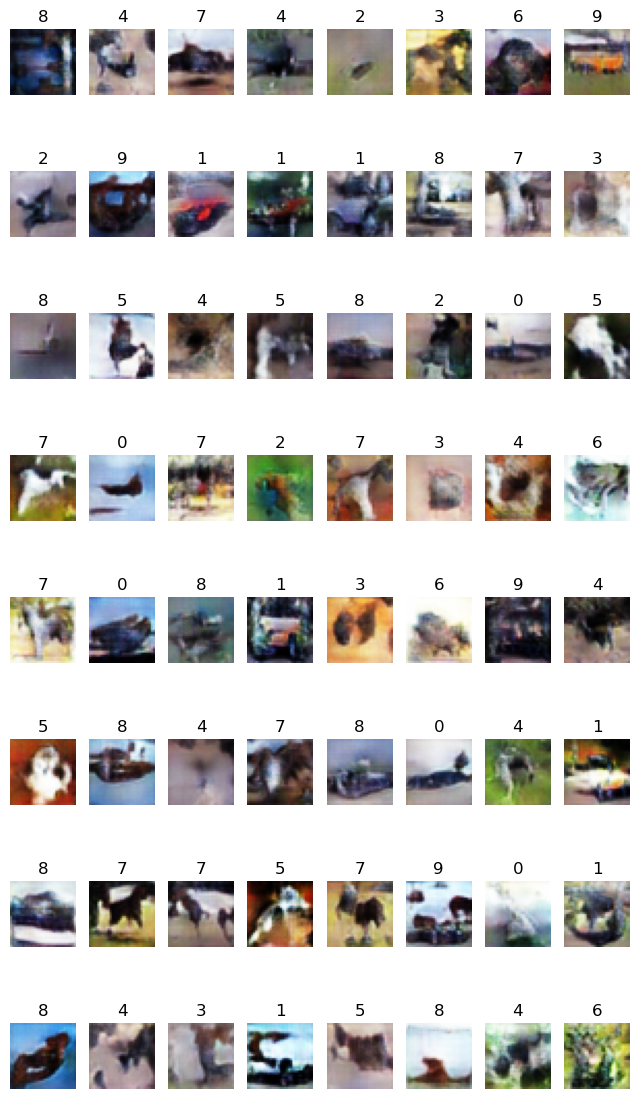

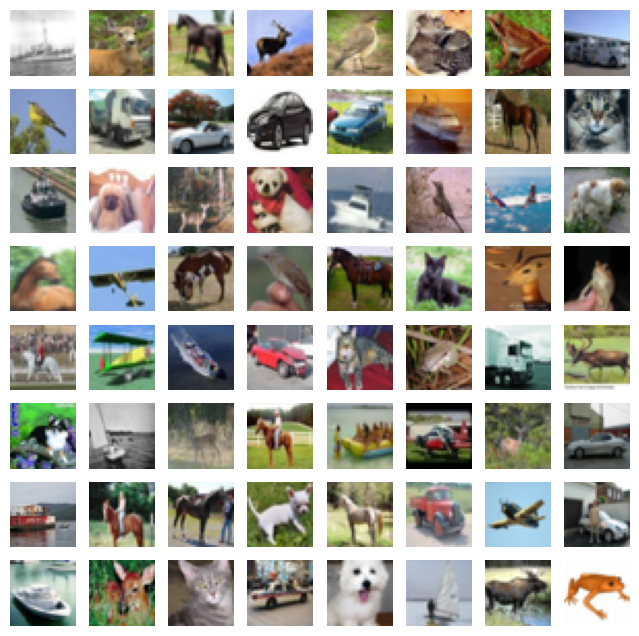

epoch :10
[0/100][0/938] Loss_D: 1.0996 Loss_G: 0.7000 D(x): 0.9624 D(G(z)): 0.5704 / 0.5704


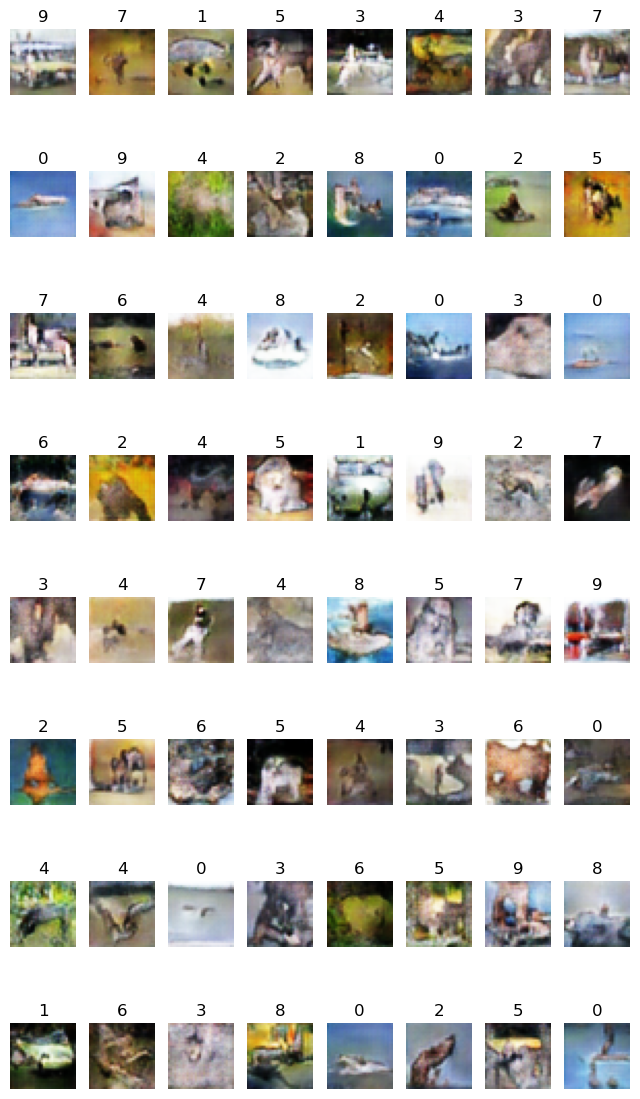

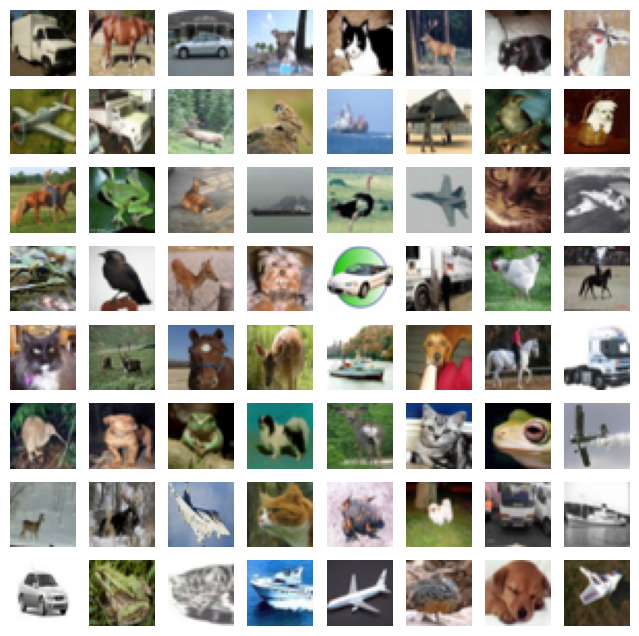

epoch :11
[0/100][0/938] Loss_D: 0.5508 Loss_G: 1.7417 D(x): 0.8858 D(G(z)): 0.2593 / 0.2593


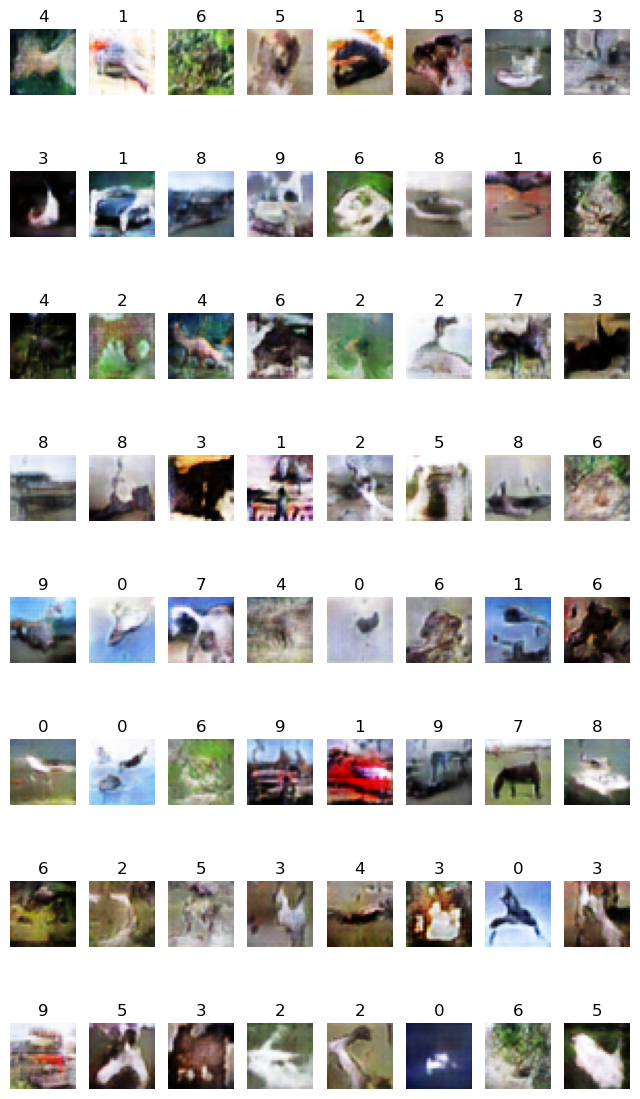

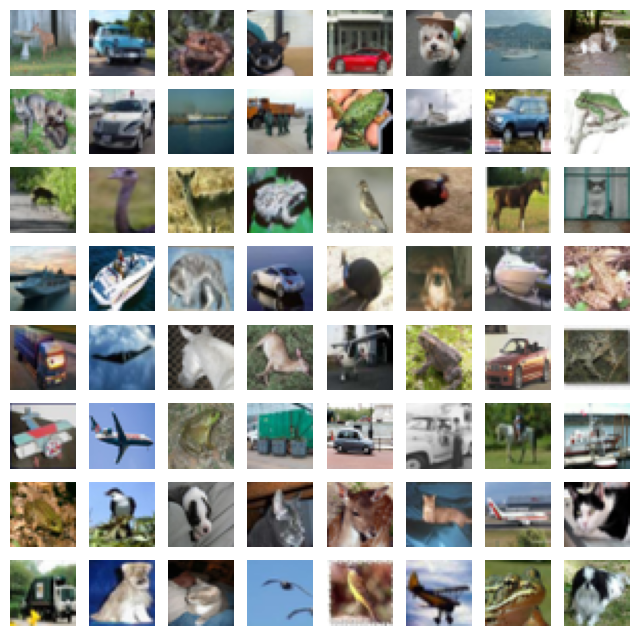

epoch :1
[0/100][0/938] Loss_D: 3.0232 Loss_G: 0.0937 D(x): 0.9067 D(G(z)): 0.9148 / 0.9148


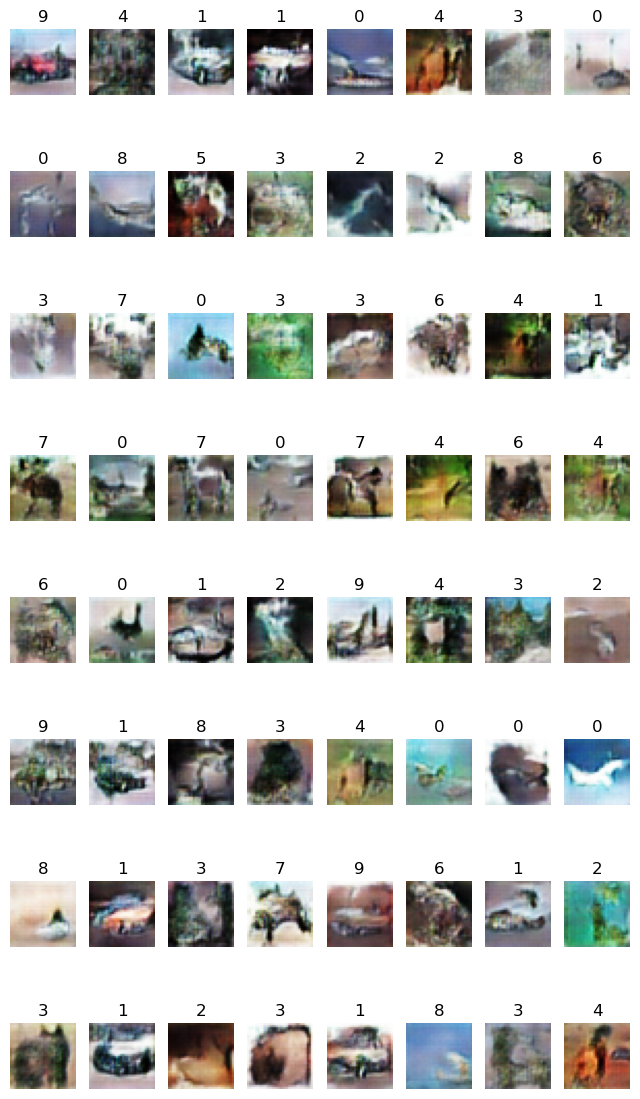

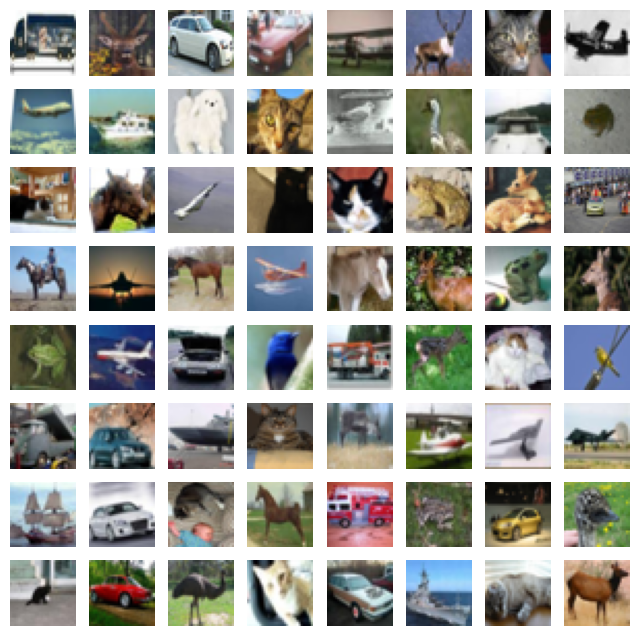

epoch :2
[0/100][0/938] Loss_D: 1.5668 Loss_G: 0.6541 D(x): 0.5323 D(G(z)): 0.5496 / 0.5496


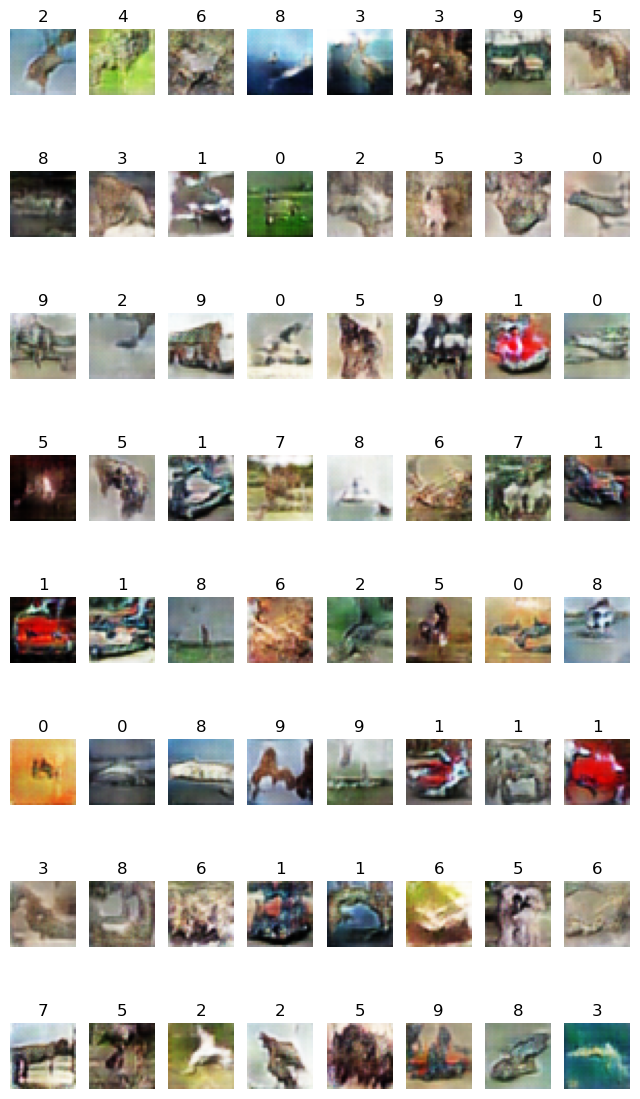

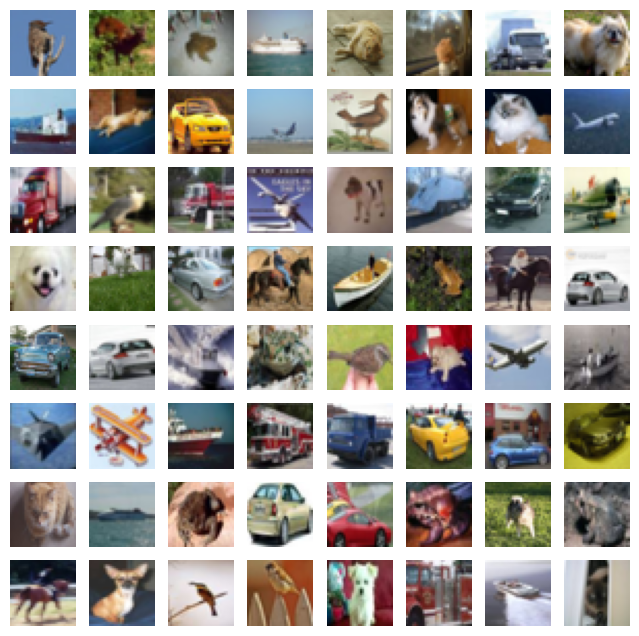

epoch :3
[0/100][0/938] Loss_D: 0.7983 Loss_G: 4.3659 D(x): 0.5203 D(G(z)): 0.0192 / 0.0192


In [3]:

IMG_SIZE = 32
import glob
for checkpointD, checkpointG in sorted(list(zip(glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/bganD_checkpoint_*.pt"),glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/bganG_checkpoint_*.pt")))):
    print("epoch :" + checkpointD.split("_")[-2].split(".")[0])
    
    checkpointD = torch.load(checkpointD)
    checkpointG = torch.load(checkpointG)
    modelG = Generator(IMG_SIZE=32, img_ch=3)
    modelD = Discriminator(img_channels=3, n_classes=10)
    modelG.load_state_dict(checkpointG['model'])
    modelD.load_state_dict(checkpointD['model'])

    modelG = modelG.to(device)
    modelD = modelD.to(device)



    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])

    ])
    train = torchvision.datasets.CIFAR10(root='/ssd_scratch/cvit/anirudhkaushik/datasets/', train=True, download=False, transform=data_transforms)
    test = torchvision.datasets.CIFAR10(root='/ssd_scratch/cvit/anirudhkaushik/datasets/', train=False, download=False, transform=data_transforms)

    data_loader = DataLoader(torch.utils.data.ConcatDataset([train, test]), batch_size=64, shuffle=True)


    # visualize
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)

    visualize(data_loader, modelG, modelD, criterion, 0, fixed_noise, device)
